## Watch the [YouTube video](https://www.youtube.com/watch?v=EOaPb9wrgDY) first for more context.

In [ ]:
import math
import json
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os
import datetime

: 

## Setting up the keyboard

### Coordinates

Start by creating a dictionary to store the coordinate positions for each key. In this project, the key labeling order will be top to bottom, left to right. This means that on a QWERTY layout, the "Q" key corresponds to index 0, "A" is 1, "Z" is 2, "W" is 3, "S" is 4, etc. The middle row and bottom row will be offset from the top row. Set these offsets to 0 to represent an ortholinear keyboard. This will create a keyboard with 30 keys.

In [ ]:
KEY_WIDTH = 94
MIDDLE_OFFSET = 24
BOTTOM_OFFSET = 71
offsets = [0, MIDDLE_OFFSET, BOTTOM_OFFSET]

coords = {}
for i1 in range(30):
    row = i1%3
    column = math.floor(i1/3)
    x = column*KEY_WIDTH + offsets[row]
    y = row*KEY_WIDTH
    coords[i1] = (x, y)
coords

: 

### Keys per finger

Define all of the key that each finger is responsible for typing. This can change depending on how many fingers you want to simulate typing with. For example, assuming 10 finger typing on a QWERTY layout, the pinky finger on the left hand will be responsible for typing the "Q", "A", and "Z" keys. Therefore, the keys 0, 1, and 2 will be grouped together in the two dimmensional array. Similarly, the the ring finger on the left hand is responsible for typing "W", "S", and "X", so the keys 3, 4, and 5 will be grouped together. We define define the keys for each finger as elements in a 2 dimensional array.

In [5]:
global keys_per_finger
keys_per_finger = [[0,1,2], [3,4,5], [6,7], [8,9,10,11,12,13,14], [15,16,17,18,19,20], [21,22,23], [24,25,26], [27,28,29]]
# The keys per finger for a 2 finger typing would be defined as follows:
# keys_per_finger = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], [15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]
# The keys per finger for a 1 finger typing would be defined as follows:
# keys_per_finger = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]

### Home keys

When typing, each finger that is used to type should have home keys defined which is their default position that they start in and return to when not actively typing. For example, for 10 finger typing on a QWERTY keyboard the home keys will be "A", "S", "D", "F", "J", "K", "L", and ";". This corresponds to keys 1, 4, 7, 10, 19, 22, 25, 28. Use a dictionary to associate each key to its corresponding home key.

In [6]:
home_key_pos = [1, 4, 7, 10, 19, 22, 25, 28]
# The home keys for a 2 finger typing would be defined as follows:
# home_key_pos = [7, 22]
# The home key for a 1 finger typing would be defined as follows:
# home_key_pos = [16]
home_keys = {}
for i1, keys in enumerate(keys_per_finger):
    for key in keys:
        home_keys[key] = home_key_pos[i1]
home_keys

{0: 1,
 1: 1,
 2: 1,
 3: 4,
 4: 4,
 5: 4,
 6: 7,
 7: 7,
 8: 10,
 9: 10,
 10: 10,
 11: 10,
 12: 10,
 13: 10,
 14: 10,
 15: 19,
 16: 19,
 17: 19,
 18: 19,
 19: 19,
 20: 19,
 21: 22,
 22: 22,
 23: 22,
 24: 25,
 25: 25,
 26: 25,
 27: 28,
 28: 28,
 29: 28}

### Keyboard object

Each keyboard will be defined as a dictionary for what character each key corresponds to. This function will convert a genome (string representing a keyboard) into a dictionary. The genome should be in order, so for the QWERTY layout, the genome will be "qazwsxedcrfvtgbyhnujmik,ol.p;/". It will also take into account shift keys like "<", ">", ":", and "?" by adding them to the dictionary with the appropriate corresponding key. 

In [7]:
def genome_to_keyboard(genome):
    keyboard = {}
    for i, char in enumerate(genome):
        keyboard[char] = i
        if char == ',':
            keyboard['<'] = i
        elif char == '.':
            keyboard['>'] = i
        elif char == ';':
            keyboard[':'] = i
        elif char == '/':
            keyboard['?'] = i
    return keyboard

## Data Collection

### arXiv.org dataset

The arXiv.org metadata dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/Cornell-University/arxiv). Download the json file and save it in the same directory as this notebook. The following code will create a collection of abstracts. It will not include any abstracts that contain illegal characters. This will reduce any unwanted data like scientific notation and math equations. In the original video, only a small subset of the dataset of 587 abtracts. The dataset is very large and calculating the distance over the entire dataset will take a very long time.

In [8]:
full_text = {}

In [9]:
ARXIV_JSON = 'arxiv-metadata-oai-snapshot.json'
DATA_LIMIT = 3000  # 2486206 条数据, 太多了, 设定30000为效率测试数

full_text['arxiv'] = ''
legal_chars = 'qazwsxedcrfvtgbyhnujmik,ol.p;:? '

count = 0
with open(ARXIV_JSON) as file:
    for line in file:
        if count > DATA_LIMIT:
            break
        abstract = json.loads(line)['abstract'].replace('\n', ' ').strip().lower()
        if any(char not in legal_chars for char in abstract):
            continue
        full_text['arxiv'] += ' ' + abstract
        count += 1

In [10]:
# 中文数据集
NOTEBOOK_JSON = 'notebook_content.json'
DATA_LIMIT2 = 324  # 3249 条, 3249为效率测试数

full_text['chinese'] = ''
legal_chars = 'qazwsxedcrfvtgbyhnujmik,ol.p;:? '

count = 0
with open(NOTEBOOK_JSON, 'r', encoding='utf-8') as file:
    for line in file:
        if count > DATA_LIMIT2:
            break
        content_pinyin = json.loads(line)['content_pinyin'].replace('\n', ' ').strip().lower()
        if any(char not in legal_chars for char in content_pinyin):
            continue
        full_text['chinese'] += ' ' + content_pinyin
        count += 1

In [11]:
#Python数据集
PYTHON_CODE='python_code2.json'
DATA_LIMIT3 = 45  # 728 条, 728为效率测试数

full_text['python'] = ''
legal_chars = 'qazwsxedcrfvtgbyhnujmik,ol.p;:? '

count = 0
with open(PYTHON_CODE, 'r', encoding='utf-8') as file:
    for line in file:
        if count > DATA_LIMIT3:
            break
        content_python = json.loads(line)['content'].replace('\n', ' ').strip().lower()
        # if any(char not in legal_chars for char in content_python):
        #     continue
        cleaned_content = ''.join([char for char in content_python if char in legal_chars]) # python不能简单跳过处理
        full_text['python'] += ' ' + cleaned_content
        count += 1


In [12]:
# 数据集长度长度
total_full_text = full_text['arxiv']+full_text['chinese']+full_text['python']
print("总计:",len(total_full_text))
percent = "{:.2f}%".format(len(full_text['arxiv'])/len(total_full_text)* 100)
percen_chinese = "{:.2f}%".format(len(full_text['chinese'])/len(total_full_text)* 100)
percent_python = "{:.2f}%".format(len(full_text['python'])/len(total_full_text)* 100)

print(f"arxiv: {len(full_text['arxiv'])}, 占比{percent}\n中文: {len(full_text['chinese'])}, 占比{percen_chinese}\nPython: {len(full_text['python'])}, 占比{percent_python}")

总计: 2175285
arxiv: 1251359, 占比57.53%
中文: 757849, 占比34.84%
Python: 166077, 占比7.63%


## Calculate distance

### Calculate distance between two keys

This simple function will calculate the distance between any two given keys, given their coordinates as input parameters

In [13]:
def distance(first, second):
    return math.hypot(second[0] - first[0], second[1] - first[1])

### Calculate distance for all letter pairings

Calculate the distance for all valid letter pairings and save it as a dictionary of dictionaries. The key in the dictionary corresponds to the starting key. The inner dictionary key is the ending key, and the inner dictionary value is the distance for that key pairing. For example, the dinstances from key 0 to keys 0, 1, and 2 will be represented as: 
```
{
  0: {
    0: 0.0, 
    1: 1.0320793902668004, 
    2: 2.1378744155702085
  }
}
       
```

In [14]:
distances = {i: {} for i in range(30)}
for keys in keys_per_finger:
    for i1 in keys:
        for j1 in keys:
            distances[i1][j1] = distance(coords[i1], coords[j1]) / KEY_WIDTH
distances

{0: {0: 0.0, 1: 1.0320793902668004, 2: 2.1378744155702085},
 1: {0: 1.0320793902668004, 1: 0.0, 2: 1.1180339887498947},
 2: {0: 2.1378744155702085, 1: 1.1180339887498947, 2: 0.0},
 3: {3: 0.0, 4: 1.0320793902668004, 5: 2.1378744155702085},
 4: {3: 1.0320793902668004, 4: 0.0, 5: 1.1180339887498947},
 5: {3: 2.1378744155702085, 4: 1.1180339887498947, 5: 0.0},
 6: {6: 0.0, 7: 1.0320793902668004},
 7: {6: 1.0320793902668004, 7: 0.0},
 8: {8: 0.0,
  9: 2.01491159083403,
  10: 1.1180339887498947,
  11: 1.0,
  12: 2.3556804581702036,
  13: 1.8027756377319948,
  14: 2.0},
 9: {8: 2.01491159083403,
  9: 0.0,
  10: 1.0320793902668004,
  11: 2.1378744155702085,
  12: 1.0,
  13: 1.6049380566507325,
  14: 2.6610421482235114},
 10: {8: 1.1180339887498947,
  9: 1.0320793902668004,
  10: 0.0,
  11: 1.1180339887498947,
  12: 1.2468157722539244,
  13: 1.0,
  14: 1.8027756377319948},
 11: {8: 1.0,
  9: 2.1378744155702085,
  10: 1.1180339887498947,
  11: 0.0,
  12: 2.01491159083403,
  13: 1.11803398874989

### Calculate total distance for a given string

This function will calculate the total distance for any given string with any given keyboard. This will fail if there are invalid characters in the string

In [15]:
def total_distance(input_string, keyboard):
    input_string = input_string.lower()
    input_string = input_string.replace(' ', '')
    first_char = input_string[0]
    first_pos = keyboard[first_char]
    first_home_key = home_keys[first_pos]
    total_dist = distances[first_home_key][first_pos]
    for i in range(0, len(input_string)-1):
        cur_char = input_string[i]
        next_char = input_string[i+1]
        cur_pos = keyboard[cur_char]
        next_pos = keyboard[next_char]
        if cur_pos in distances and next_pos in distances[cur_pos]:
            total_dist += distances[cur_pos][next_pos]
        else:
            home_key = home_keys[next_pos]
            total_dist += distances[home_key][next_pos]
    return total_dist

### Test the distance

Calculate the total distance for a test string.

In [16]:
layout = {}  # 创建一个空字典

# 向字典中添加键值对
layout['qwerty'] = 'qazwsxedcrfvtgbyhnujmik,ol.p;/'
layout['qwertz'] = 'qaywsxedcrfvtgbzhnujmik,ol.p;/'
layout['devorak'] = '/a;,oq.ejpukyixfdbghmctwrnvlsz'
layout['colemak'] = 'qazwrxfscptvgdbjhklnmue,yi.;o?'
layout['rstlne'] = 'qagwsxdecfrvzl/;hbunjkimyo,pt.'
# layout['cyletix1'] = 'qazwsxdecrtv;gbyhjunmki,fo.pl/'
# layout['cyletix2'] = 'qazwsxdecrtvfgbyhjunmki,lo.p;/'
# layout['cyletix3'] = 'qazwsxdecrtvfgbyhnjumki,lo.p;/'
# layout['cyletix31'] = 'qazwsxdecrtvfgbyhnkjmiu,lo.p;/'
# layout['cyletix32'] = 'qazwsxdecrtvfgb;hnyjmki,lo.pu/'
# layout['cyletix33'] = 'qazwsxdecrtvfgbyhnkjmui,lo.p;/'
# layout['cyletix34'] = 'qazwsxdecrtvfgbyhnjlmki,po.;u/'
# layout['cyletix4'] = 'qazwsxdecrtv/g,;h.jumkifloypnb'
# layout['cyletix5'] = 'qazwsxdecrtv,gb.hnjumkifloyp;/'
# layout['cyletix6'] = 'qazwsxdecrtv,gb.hnjumkiylo;pf/'
# layout['cyletix7'] = 'qrzhsjdncftg;lbyuxwemvi,ko.pa/'
# layout['cyletix8'] = 'qhrfnjdtczsg;lbyuxwemvi,ko.pa/'
layout['cyletix10'] = 'qazwsxdecrtvfgb;hnjlmki,yo.pu/'

Calculate the total distance for the entire dataset.

In [17]:
KeyboardLayout=(genome_to_keyboard(list(layout['cyletix10'])))
total_distance(full_text['arxiv'], KeyboardLayout)

518358.48707694106

### 连续重复手指次数计算

In [18]:
# 定义每个手指负责的键位
fingerMap = {}
for fingerIndex, keyIndexes in enumerate(keys_per_finger):
    for index in keyIndexes:
        fingerMap[index] = fingerIndex

# 计算同一手指连续输入的次数
def finger_repeat(text,KeyboardLayout):
    sameFingerCount = 0
    lastFinger = None
    for char in text:
        keyIndex = KeyboardLayout.get(char)  # 直接使用字典查找字符索引
        if keyIndex is not None:
            currentFinger = fingerMap.get(keyIndex)
            if currentFinger is not None and currentFinger == lastFinger:
                sameFingerCount += 1
            lastFinger = currentFinger
    return sameFingerCount

# 在原有的数据处理基础上添加新功能
KeyboardLayout=(genome_to_keyboard(list(layout['cyletix10'])))
sameFingerRepeats = finger_repeat(full_text['arxiv'],KeyboardLayout)
print(f"同一手指连续输入的次数为：{sameFingerRepeats}")


同一手指连续输入的次数为：92212


### 定义汉明距离
用于衡量两个布局的相似程度, 越小越相似

In [19]:
def cal_hamming_distance(layout1, layout2):
    if len(layout1) != len(layout2):
        raise ValueError("两个布局必须有相同数量的键位")
    return sum(c1 != c2 for c1, c2 in zip(layout1, layout2))

# 计算距离
hamming_distance = cal_hamming_distance(layout['qwerty'], layout['cyletix10'])
print("两个布局之间的汉明距离是:", hamming_distance)


两个布局之间的汉明距离是: 12


### 优化距离
定义一个新的距离, 这个距离的定义依赖于手指的分配, 在这个距离下如果两个布局之间的差异导致位置变化为1, 分配手指变化则距离为2; 如果左右手都改变的话, 距离为3

In [20]:

def cal_punish_distance(layout1, layout2):
    if len(layout1) != len(layout2):
        raise ValueError("两个布局必须有相同数量的键位")


    distance_punish=0
    # 构建反向索引字典
    layout1_dict = {}
    for i, finger_keys in enumerate(keys_per_finger):
        for j, key_index in enumerate(finger_keys):
            value = layout1[key_index]
            if value not in layout1_dict:
                layout1_dict[value] = []
            layout1_dict[value].append((i, j))

    # 遍历 layout2 并检查是否存在于 layout1_dict
    for i_1, finger_keys in enumerate(keys_per_finger):
        for j_1, key_index in enumerate(finger_keys):
            value = layout2[key_index]
            if value in layout1_dict:
                i_2, j_2 = layout1_dict[value][0]  # 获取第一个匹配的索引
                break

        # 判断同一手指是否在不同的列
        if j_1 != j_2:
            distance_punish += 1
        
        # 判断同一手指是否在不同的行，且在同一边（左手或右手）
        if i_1 != i_2 and (i_1 - 5) * (i_2 - 4) > 0:
            distance_punish += 1

        # 判断同一手指是否跨越了中轴线（左右手交换）
        if i_1 != i_2 and j_1 != j_2 and (i_1 - 5) * (i_2 - 4) < 0:
            distance_punish += 1

    return distance_punish

# 计算距离
advanced_distance = cal_punish_distance(layout['qwerty'], layout['devorak'])
print("两个布局之间的改进距离是:", advanced_distance)


两个布局之间的改进距离是: 13


In [21]:
# 结果汇总
print(f"Layout\tkeys\tarxiv\tchinese\tpython\thamming\tpunish\trepeat")

for layout_name, keys in layout.items():
    KeyboardLayout=(genome_to_keyboard(list(layout[layout_name]))) 
    results = []
    for language, text in full_text.items():
        distance = total_distance(text, KeyboardLayout)
        results.append(f"{int(distance)}\t")
    results.append(f"{cal_hamming_distance(layout['qwerty'], keys)}\t")
    results.append(f"{cal_punish_distance(layout['qwerty'], keys)}\t")
    repeat_count = 0
    for language, text in full_text.items():
        repeat_count += finger_repeat(full_text[language],KeyboardLayout)
    results.append(f"{repeat_count}\t")
    print(f"{layout_name}\t{keys}\t", "".join(results))

Layout	keys	arxiv	chinese	python	hamming	punish	repeat
qwerty	qazwsxedcrfvtgbyhnujmik,ol.p;/	 905782	506503	103831	0	0	176943	
qwertz	qaywsxedcrfvtgbzhnujmik,ol.p;/	 898213	507934	103601	2	2	187169	
devorak	/a;,oq.ejpukyixfdbghmctwrnvlsz	 500412	325192	69279	28	13	148019	
colemak	qazwrxfscptvgdbjhklnmue,yi.;o?	 417029	316830	60409	18	5	103387	
rstlne	qagwsxdecfrvzl/;hbunjkimyo,pt.	 415583	314191	61834	20	4	151085	
cyletix10	qazwsxdecrtvfgb;hnjlmki,yo.pu/	 518358	331261	65249	12	4	141764	


In [22]:
def extract_punctuation_positions(s):
    return {i: char for i, char in enumerate(s) if not char.isalnum()}


# 调用函数并打印结果
fixed_positions = extract_punctuation_positions(layout['cyletix10'])
print(fixed_positions)


{15: ';', 23: ',', 26: '.', 29: '/'}


## Genetic Algorithm

### Initialize the population

This function will initialize the population for the first generation with random keyboards for a given population size.

In [23]:
def init_population(pop_size):
    keyboard_chars = list(layout['colemak'])
    population = []
    for i in range(pop_size):
        
        # rand_gnome = keyboard_chars[:]
        # random.shuffle(rand_gnome)
        letters = [char for char in keyboard_chars if char.isalpha()]
        punctua = [(index, char) for index, char in enumerate(keyboard_chars) if not char.isalpha()]
        random.shuffle(letters)
        rand_gnome = [letters.pop(0) if index not in [p_index for p_index, p_char in punctua] else char for index, char in enumerate(keyboard_chars)]

        population.append(rand_gnome)
    return population

In [24]:
# 洗牌测试
keyboard_chars = list(layout['cyletix10'])     
letters = [char for char in keyboard_chars if char.isalpha()]
punctua = [(index, char) for index, char in enumerate(keyboard_chars) if not char.isalpha()]
random.shuffle(letters)
rand_gnome = [letters.pop(0) if index not in [p_index for p_index, p_char in punctua] else char for index, char in enumerate(keyboard_chars)]

result = ''.join(rand_gnome)
print(layout['cyletix10'])
print(result)

qazwsxdecrtvfgb;hnjlmki,yo.pu/
poduixtlzkvwych;egqmbfr,ja.sn/


In [25]:
# def init_population(pop_size):
#     keyboard_chars = list(layout['cyletix10'])
#     population = []
#     for _ in range(pop_size):
#         # 使用 extract_punctuation_positions 获取标点符号及其位置
#         punctuations = extract_punctuation_positions(layout['cyletix10'])
        
#         # 提取字母
#         letters = [char for char in keyboard_chars if char.isalnum()]
        
#         # 打乱字母
#         random.shuffle(letters)
        
#         # 重新构建个体基因组，保留标点符号位置
#         rand_gnome = [letters.pop(0) if index not in punctuations else punctuations[index] for index in range(len(keyboard_chars))]
        
#         # 将生成的基因组添加到种群中
#         population.append(rand_gnome)
    
#     return population


### Combine two keyboards

This function defines the logic for "mating" two keyboards to create a new keyboard. The function will select a random point to split the keyboards. It will begin filling in the child keyboard to the right of the split point with a random number of keys from the first keyboard. It will then fill in the remaining keys with keys from keyboard 2. There is also a random chance of mutation where two keys on the child keyboard will switch places.

In [26]:
def mate(board1, board2, mutation_rate):
    keyboard_size = len(board1)
    idx = random.randint(0, keyboard_size-1)
    length = random.randint(0,keyboard_size-1)
    child = ['_' for i in range(keyboard_size)]
    for i in range(length):
        if idx > keyboard_size-1:
            idx = 0
        child[idx] = board1[idx]
        idx += 1

    child_idx = idx
    while '_' in child:
        if idx > keyboard_size-1:
            idx = 0
        if child_idx > keyboard_size-1:
            child_idx = 0
        char = board2[idx]
        if char in child:
            idx += 1
            continue
        child[child_idx] = board2[idx]
        child_idx += 1
        idx += 1
        
    prob = random.random()
    if prob < mutation_rate:
        point1 = random.randint(0, 29)
        point2 = random.randint(0, 29)
        allele1 = child[point1]
        allele2 = child[point2]
        child[point1] = allele2
        child[point2] = allele1
        
    return child

In [34]:
# def mate(board1, board2, mutation_rate):
#     keyboard_size = len(board1)
    
#     # 假设 board1 是从某个基础字符串派生的，这里我们需要这个基础字符串来提取固定位置
#     base_string = 'qazwsxedcrfvtgbyhnujmik,ol.p;/'  # 这应该是定义键盘布局的原始字符串
#     fixed_positions = extract_punctuation_positions(base_string)

#     idx = random.randint(0, keyboard_size-1)
#     length = random.randint(0, keyboard_size-1)
#     child = [board1[i] if i in fixed_positions else '_' for i in range(keyboard_size)]
    
#     # Fill the child array while respecting fixed positions
#     for i in range(length):
#         if idx >= keyboard_size:
#             idx = 0
#         if idx not in fixed_positions:
#             child[idx] = board1[idx]
#         idx += 1

#     # Continue filling from the second board
#     child_idx = idx
#     while '_' in child:
#         if idx >= keyboard_size:
#             idx = 0
#         if child_idx >= keyboard_size:
#             child_idx = 0
        
#         if child[child_idx] == '_':
#             char = board2[idx]
#             if char not in child:
#                 child[child_idx] = char
#                 child_idx += 1
#         idx += 1
        
#     # Perform mutation, avoiding fixed positions
#     prob = random.random()
#     if prob < mutation_rate:
#         while True:
#             point1 = random.randint(0, keyboard_size-1)
#             point2 = random.randint(0, keyboard_size-1)
#             if point1 not in fixed_positions and point2 not in fixed_positions:
#                 allele1 = child[point1]
#                 allele2 = child[point2]
#                 child[point1] = allele2
#                 child[point2] = allele1
#                 break
    
#     return child


### Evaluate the population

This function will evaluate a given population by calcualating the total distance for each keyboard in the population. It returns the evals as a dictionary. It also returns the indicies sorted in order of the total distance of the keyboard at that index.

In [28]:
def get_evals(population):
    evals = {}
    for i, genome in enumerate(population):
        keyboard = genome_to_keyboard(genome)
        
        dist = total_distance(total_full_text, keyboard)

        # repeat_count = finger_repeat(total_full_text,keyboard) #重复
        # evals[i] = int(dist*(repeat_count+20)/20000000) #dist

        # dist_qwerty=total_distance(total_full_text,genome_to_keyboard(layout['qwerty']))
        pop_hamming_dist=cal_hamming_distance(layout['qwerty'], genome)
        pop_punish_dist=cal_punish_distance(layout['qwerty'], genome)
        evals[i] = int((dist)*(pop_hamming_dist+pop_punish_dist+100)/20000) #dist

    sorted_evals = [k for k, v in sorted(evals.items(), key=lambda item: item[1])]
    return evals, sorted_evals

### Create next generation

This function will create a new generation from the current population. It will directly copy the top 10% best keyboards from the current generation to the next generation. It will then randomly combine keyboards from the top 50% best keyboards to create the remaining population for the next generation.

In [29]:
def new_generation(population, sorted_evals, p_size, mutation_rate):
    new_gen = []
    
    sorted_population = []
    for i in sorted_evals:
        sorted_population.append(population[i])
        
    for i in range(int(p_size*0.1)):
        new_gen.append(sorted_population[i])

    for _ in range(int(p_size*0.9)):
        p1 = random.choice(sorted_population[:int(p_size*0.5)])
        p2 = random.choice(sorted_population[:int(p_size*0.5)])
        child = mate(p1, p2, mutation_rate)
        new_gen.append(child)
    
    return new_gen

### Run the algorithm

The following code will run the genetic algorithm. Adjust the constants `P_SIZE` to change the population size, `GENERATIONS` to change the total number of generations the algorithm will run, and `MUTATION_RATE` to change how often mutations occur during mating. The training data will be stored to the `learning` dictionary and be saved to a json file once the algorithm is complete. This will contain information for each generation. It will contain the total every keyboard in the population, the best keyboard in the population, the lowest distance of the best keyboard, and the average distance of all the keyboards.

In [39]:
P_SIZE = 100
GENERATIONS = 10
MUTATION_RATE = 0.2

learning = {
    'generations': {}
}

population = init_population(P_SIZE)

### 加载种群状态

In [40]:
LEARNING_JSON = 'output/learning4.json'

def load_population():
    if os.path.exists(LEARNING_JSON):
        with open(LEARNING_JSON, 'r') as fp:
            data = json.load(fp)
            last_gen_number = max(data['generations'].keys(), key=int)
            last_generation = data['generations'][last_gen_number]
            return last_generation['population'], int(last_gen_number) + 1
    else:
        return init_population(P_SIZE), 0  # 初始化种群如果没有现成的学习状态

population, start_generation = load_population()

In [38]:

for i1 in range(GENERATIONS):    
    evals, sorted_evals = get_evals(population)
    sum_evals = 0
    for key in evals:
        sum_evals += evals[key]
    avg_evals = sum_evals/P_SIZE
    learning['generations'][i1] = {
        'population': population,
        'best': population[sorted_evals[0]],
        'min': evals[sorted_evals[0]],
        'avg': avg_evals
    }
    print('GEN: {}, AVG: {}, MIN: {}, BEST: {}'.format(i1+1, avg_evals, evals[sorted_evals[0]], population[sorted_evals[0]]))
    
    population = new_generation(population, sorted_evals, P_SIZE, MUTATION_RATE)



timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
learning_filename = f'learning-{timestamp}.json'
with open(learning_filename, 'w') as fp:
    json.dump(learning, fp)
LEARNING_JSON = 'output/learning5.json'
with open(LEARNING_JSON, 'w') as fp:
    json.dump(learning, fp)

GEN: 1, AVG: 4599.0, MIN: 4578, BEST: ['q', 'a', 'z', 'w', 's', 'x', 'p', 'i', 'j', 'r', 'h', 'f', 'k', 'd', ';', '?', 'l', 'c', 'g', 'n', 'm', 'b', 't', 'v', 'u', 'o', '.', 'y', 'e', ',']
GEN: 2, AVG: 4636.6, MIN: 4568, BEST: ['q', 'a', 'z', 'w', 's', 'x', 'p', 'i', 'j', 'r', 'h', 'f', 'k', 'd', ';', '?', 'l', 'c', 'b', 'n', 'm', 'g', 't', 'v', 'u', 'o', '.', 'y', 'e', ',']
GEN: 3, AVG: 4630.19, MIN: 4568, BEST: ['q', 'a', 'z', 'w', 's', 'x', 'p', 'i', 'j', 'r', 'h', 'f', 'k', 'd', ';', '?', 'l', 'c', 'b', 'n', 'm', 'g', 't', 'v', 'u', 'o', '.', 'y', 'e', ',']
GEN: 4, AVG: 4657.73, MIN: 4568, BEST: ['q', 'a', 'z', 'w', 's', 'x', 'p', 'i', 'j', 'r', 'h', 'f', 'k', 'd', ';', '?', 'l', 'c', 'b', 'n', 'm', 'g', 't', 'v', 'u', 'o', '.', 'y', 'e', ',']
GEN: 5, AVG: 4785.98, MIN: 4568, BEST: ['q', 'a', 'z', 'w', 's', 'x', 'p', 'i', 'j', 'r', 'h', 'f', 'k', 'd', ';', '?', 'l', 'c', 'b', 'n', 'm', 'g', 't', 'v', 'u', 'o', '.', 'y', 'e', ',']
GEN: 6, AVG: 4738.75, MIN: 4568, BEST: ['q', 'a', 'z

KeyboardInterrupt: 

### Visualize the training

This code will take a learning json file and plot the data. It will plot one graph as the average distance for each generation, and another graph for the best distance for each generation.

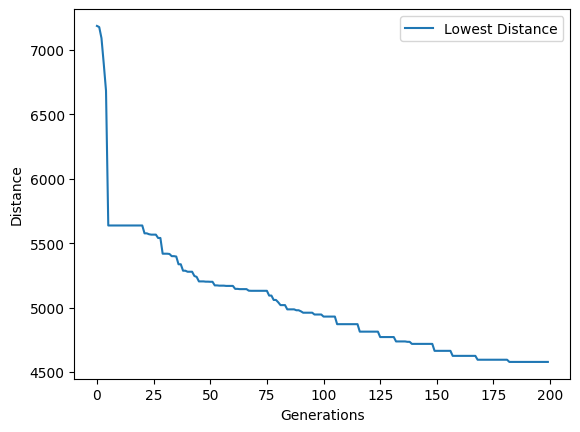

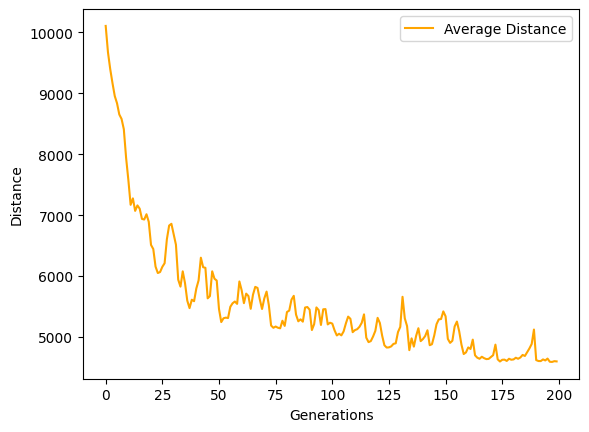

In [31]:
with open(LEARNING_JSON) as fp:
    learning = json.load(fp)
    
last_dist = 1000000000
min_dists = []
avg_dists = []
generations = len(learning['generations'])

for i1 in range(0, generations):
    min_dist = learning['generations'][str(i1)]['min']
    avg_dist = learning['generations'][str(i1)]['avg']
    min_dists.append(min_dist)
    avg_dists.append(avg_dist)

plt.plot(min_dists, label='Lowest Distance')
plt.xlabel('Generations')
plt.ylabel('Distance')
plt.legend()
plt.show()

plt.plot(avg_dists, label='Average Distance', color='orange')
plt.xlabel('Generations')
plt.ylabel('Distance')
plt.legend()
plt.show()

### Visualizing keyboards

The following code will create an image for any keyboard string to help visualize what layout the keyboard string corresponds to. This isn't needed, but can be helpful when viewing keyboards generated by the genetic algorithm.

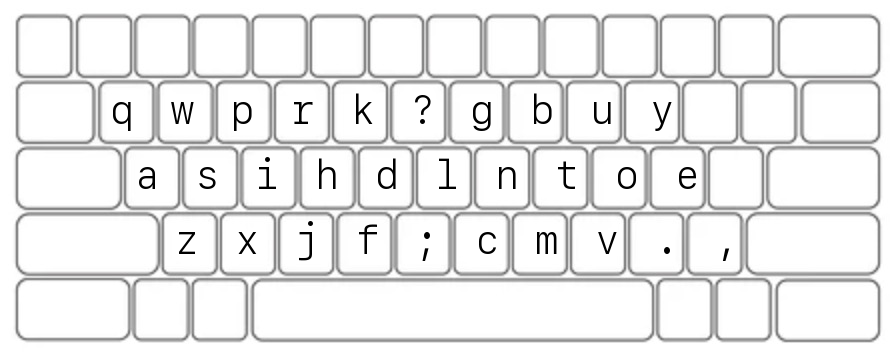

In [32]:
kb = learning['generations'][str(GENERATIONS-1)]['best'] # best keyboard found
layout['ga_best']=''.join(kb)

with Image.open("template.jpg").convert("RGBA") as base:

    # make a blank image for the text, initialized to transparent text color
    txt = Image.new("RGBA", base.size, (255, 255, 255, 0))

    # get a font
    fnt = ImageFont.truetype("SFNSMono.ttf", 40)
    # get a drawing context
    d = ImageDraw.Draw(txt)
    
    x_offsets = [110, 135, 175]
    for i1 in range(30):
        row = i1%3
        column = math.floor(i1/3)
        x = column*60 + x_offsets[row]
        y = row*65 + 85
        char_coords = (x, y)
        d.text(char_coords, kb[i1], font=fnt, fill=(0, 0, 0, 255))

    out = Image.alpha_composite(base, txt)

    display(out)

In [33]:
# 结果汇总
print(f"Layout\tkeys\tarxiv\tchinese\tpython\thamming\tpunish\trepeat")

for layout_name, keys in layout.items():
    KeyboardLayout=(genome_to_keyboard(list(layout[layout_name]))) 
    results = []
    for language, text in full_text.items():
        distance = total_distance(text, KeyboardLayout)
        results.append(f"{int(distance)}\t")
    results.append(f"{cal_hamming_distance(layout['qwerty'], keys)}\t")
    results.append(f"{cal_punish_distance(layout['qwerty'], keys)}\t")
    repeat_count = 0
    for language, text in full_text.items():
        repeat_count += finger_repeat(full_text[language],KeyboardLayout)
    results.append(f"{repeat_count}\t")
    print(f"{layout_name}\t{keys}\t", "".join(results))

Layout	keys	arxiv	chinese	python	hamming	punish	repeat
qwerty	qazwsxedcrfvtgbyhnujmik,ol.p;/	 905782	506503	103831	0	0	176943	
qwertz	qaywsxedcrfvtgbzhnujmik,ol.p;/	 898213	507934	103601	2	2	187169	
devorak	/a;,oq.ejpukyixfdbghmctwrnvlsz	 500412	325192	69279	28	13	148019	
colemak	qazwrxfscptvgdbjhklnmue,yi.;o?	 417029	316830	60409	18	5	103387	
rstlne	qagwsxdecfrvzl/;hbunjkimyo,pt.	 415583	314191	61834	20	4	151085	
cyletix10	qazwsxdecrtvfgb;hnjlmki,yo.pu/	 518358	331261	65249	12	4	141764	
ga_best	qazwsxpijrhfkd;?lcgnmbtvuo.ye,	 418903	258179	61393	21	3	136435	
